<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New ResNet

In [0]:
import tensorflow as tf

In [0]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import  l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005

In [0]:
def initial_conv(input):
  x = Convolution2D(16,(3,3),padding="same", kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay),use_bias=False)(input)
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  return x

In [0]:
def expand_conv(init, base, k, strides = (1,1)):
  x = Convolution2D(base * k, kernel_size=(3,3),padding= "same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay),
                    use_bias=False)(init)
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon= 1e-5, gamma_initializer= 'uniform')(x)
  x = Activation('relu')(x)

  x = Convolution2D(base * k, kernel_size=(3,3), padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(weight_decay),
                    use_bias = False)(x)
  skip = Convolution2D(base * k, kernel_size=(1,1), padding='same', strides=strides, kernel_initializer='he_normal',
                       kernel_regularizer=l2(weight_decay),
                       use_bias = False)(init)
  m = Add()([x, skip])
  return m

In [0]:
def conv1_block(input, k=1, dropout = 0.0):
  init = input
  
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
  x = Activation('relu')(x)
  x = Convolution2D(16 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                    use_bias=False)(x)
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(16 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',kernel_regularizer=l2(weight_decay),
                    use_bias = False)(x)
  m = Add()([init, x])
  return m

In [0]:
def  conv2_block(input, k=1, dropout = 0.0):
  init = input

  channel_axis = 1 

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
  x = Activation('relu')(x)
  x = Convolution2D(32 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer = l2(weight_decay), use_bias = False)(x)
  
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(32*k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer= l2(weight_decay),
                    use_bias = False)(x)
  
  m = Add()([init, x])
  return m


In [0]:
def conv3_block(input, k=1, dropout=0.0):
  init = input

  channel_axis = 1 

  x = BatchNormalization(axis=channel_axis, momentum= 0.1, epsilon = 1e-5, gamma_initializer='uniform' )(input)
  x = Activation('relu')(x)
  x = Convolution2D(64 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer= l2(weight_decay),
                    use_bias = False)(x)
  
  if dropout > 0.0: x = Dropout(dropout)(x)

  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  x = Convolution2D(64 * k, kernel_size=(3,3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay),
                    use_bias=False)(x)
  m = Add()([init, x])
  return m


In [0]:
def create_wide_residual_network(input_dim, nb_classes=4, N=2, k=2, dropout = 0.0, verbose=1):
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1

  ip = Input(shape=input_dim)

  x = initial_conv(ip)
  nb_conv = 4
  x = expand_conv(x, 16, k)
  nb_conv +=2

  for i in range(N-1):
    x = conv1_block(x, k, dropout)
    nb_conv +=2
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)

  x = expand_conv(x, 32, k, strides=(1, 1))
  nb_conv += 2
  for i in range(N - 1):
    x = conv2_block(x, k, dropout)
    nb_conv += 2
  
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  
  x = expand_conv(x, 64, k, strides=(1, 1))
  nb_conv += 2
  
  for i in range(N - 1):
    x = conv3_block(x, k, dropout)
    nb_conv += 2
    
  x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  
  x = AveragePooling2D((8, 8))(x)
  x = Flatten()(x)
  
  x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)
  
  model = Model(ip, x)
  
  if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
  
  return model





In [129]:
if __name__ == "__main__":
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    init = (68, 100,1)
    wrn28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout = 0.0, verbose=1)
  

Wide Residual Network-16-2 created.


In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [156]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
#X_train, X_test, y_train,y_test = train_test_split(new_data_X, Y_data,test_size=0.33,shuffle=True)

In [0]:
from sklearn.utils import shuffle
#X_train, y_train = shuffle(X_train, y_train)

In [167]:
X_train = new_data_X.astype('float32')
X_train[0].shape

(68, 100)

In [0]:

img_rows, img_cols = X_train[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    input_shape = (1, img_rows, img_cols)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe
y_train_df = pd.DataFrame(Y_data, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])

In [0]:
X_train, X_test, y_train,y_test = train_test_split(X_train, to_categorical(y_train_df['New']),test_size=0.33,shuffle=True)

In [0]:
from tensorflow.keras.optimizers import SGD

EPOCHS = 200
BS = 128

In [0]:
sgd = SGD(lr=0.1, momentum=0.9)

In [173]:
wrn28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping


In [175]:
X_train.shape

(3833, 68, 100, 1)

In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [145]:
 hist = wrn28_10.fit(X_train, y_train, 
                        batch_size=BS, epochs=EPOCHS, verbose=1,
                        validation_data=(X_test,y_test), shuffle=True, callbacks=[lr_scheduler])

Epoch 1/200
30/30 [==============================] - 16s 529ms/step - loss: 2.4286 - acc: 0.3444 - val_loss: 2.5457 - val_acc: 0.3483 - lr: 0.1000
Epoch 2/200
30/30 [==============================] - 15s 515ms/step - loss: 2.2757 - acc: 0.4380 - val_loss: 2.2390 - val_acc: 0.4410 - lr: 0.1000
Epoch 3/200
30/30 [==============================] - 15s 515ms/step - loss: 2.1454 - acc: 0.4949 - val_loss: 2.1853 - val_acc: 0.4584 - lr: 0.1000
Epoch 4/200
30/30 [==============================] - 15s 514ms/step - loss: 2.0489 - acc: 0.5213 - val_loss: 2.0628 - val_acc: 0.5024 - lr: 0.1000
Epoch 5/200
30/30 [==============================] - 15s 514ms/step - loss: 1.9316 - acc: 0.5520 - val_loss: 2.0063 - val_acc: 0.5135 - lr: 0.1000
Epoch 6/200
30/30 [==============================] - 15s 515ms/step - loss: 1.8439 - acc: 0.5784 - val_loss: 2.0058 - val_acc: 0.5304 - lr: 0.1000
Epoch 7/200
30/30 [==============================] - 15s 515ms/step - loss: 1.7448 - acc: 0.6058 - val_loss: 1.9668 - 

KeyboardInterrupt: ignored

In [0]:
#hist = wrn28_10.fit(X_train, to_categorical(y_train_df['New']), validation_split=0.33, epochs=EPOCHS, batch_size=BS, verbose=2)

In [0]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [178]:
hist_1 = wrn28_10.fit_generator(aug.flow(X_train, y_train, batch_size=BS),validation_data=(X_test, y_test),callbacks =[lr_scheduler],verbose=1, epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
30/30 [==============================] - 16s 544ms/step - loss: 1.9087 - acc: 0.3999 - val_loss: 1.4611 - val_acc: 0.4426 - lr: 0.1000
Epoch 2/200
30/30 [==============================] - 16s 523ms/step - loss: 1.4513 - acc: 0.4318 - val_loss: 1.4212 - val_acc: 0.4558 - lr: 0.1000
Epoch 3/200
30/30 [==============================] - 16s 521ms/step - loss: 1.3905 - acc: 0.4871 - val_loss: 1.3084 - val_acc: 0.5331 - lr: 0.1000
Epoch 4/200
30/30 [==============================] - 16s 521ms/step - loss: 1.3562 - acc: 0.4931 - val_loss: 1.3522 - val_acc: 0.4881 - lr: 0.1000
Epoch 5/200
30/30 [==============================] - 16s 522ms/step - loss: 1.3162 - acc: 0.5085 - val_loss: 1.2383 - val_acc: 0.5580 - lr: 0.1000
Epoch 6/200
30/30 [==============================] - 16s 522ms/step - loss: 1.2961 - acc: 0.5270 - val_loss: 1.3042 - val_acc: 0.5008 - lr: 0.1000
Epoch 7/200
30/30 [=======================

In [0]:
wrn28_10.save("model_last.h5")

In [181]:
img = X_train[8]
img.shape

(68, 100, 1)

In [186]:
y_train[8]

array([0., 1., 0., 0.], dtype=float32)

In [184]:
np.argmax(wrn28_10(image))

1

In [198]:
y_train_df['Label'])

ValueError: ignored

5722

In [0]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (68, 100))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector

In [0]:
import tensorflow as tf
image = tf.convert_to_tensor(img)
image = preprocess(image)
image.shape

In [0]:
probs = wrn28_10.predict(image,batch_size=None,steps=1)

label = tf.one_hot(2, probs.shape[-1])
label = tf.reshape(label, (1, probs.shape[-1]))
label

In [0]:
probs

In [0]:
wrn28_10(image)

In [0]:
np.argmax(probs)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


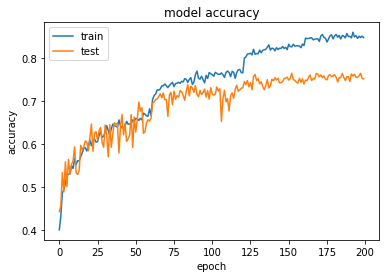

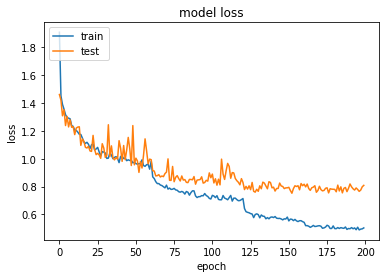

In [211]:
import matplotlib.pyplot as plt

history = hist_1
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = wrn28_10

In [0]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

In [0]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [0]:
epsilon = 0.05

adv_example_untargeted_label = fast_gradient_method(logits_model, image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

In [0]:
np.argmax(adv_example_untargeted_label_pred)